# Klusterianalyysi talouden sovelluksissa

_Kllusterianalyysi_ on tilastotieteen ja data-analytiikan menetelmä, jonka pyrkimyksenä on muodostaa joukon jäsenistä samanlaisten ominaisuuksien mukaisia ryhmiä. Ennustavassa analytiikassa klusterointi on usein pääasiallinen ratkaistava ongelma ja sillä on myös sovelluksia monella alalla, kuten koneoppimisessa, hahmontunnistuksessa, informaationhaussa ja tietokonegrafiikassa.

## Johdanto

Talouslaskennan sovelluksissa klusterianalyysia käytetään usein asiakasryhmien muodostamisessa. Ryhmät voidaan muodostaa esim. myyntisuoritusten suuruuden mukaan, valheellisten vakuutuskorvaushakemusten tunnistamisessa, väestötilastollisessa ryhmittelyssä tai luottokelpoisuuden tunnistamisessa.

Klusterianalyysi on ohjaamaton koneoppimisen algoritmi. Etukäteen ennen mallin ajamista ei tiedetä, kuinka monta klusteria (rypästä) aineistossa on. Klusterianalyysia sovelletaan yleensä, kun rippuvuuksien määrä aineistossa ei ole tiedossa. Tekniikka kertoo tuloksena, millaisia riippuvuuksia tai rakennetta aineistossa esiintyy, mutta ei sitä, mitä nuo riippuvuudet ovat tai mitä ne tarkoittavat.

On myös hyvä huomata, että klusterointi ja klusterianalyysi eivät ole aivan synonyymeja. Klusterointi on ryhmien (klusterien, ryppäiden) etsimista aineistosta ja se on toki oleellinen, tärkeä osa klusterianalyysia. Klusterointia varten on erilaisia algoritmeja, kuten k-means, DBSCAN, hierarkinen klusterointi jne. Klusterisanalyysi käsittää paitsi klusteroinnin myös siihen liittyvän analysoinnin ja klusterien tulkinnat, eritoten koko päätöksenteon prosessin ja lopputuloksen, joka näiden analyysien avulla saavutetaan.

Tässä muistiossa kuvataan vaiheittain klusterianalyysin vaiheet Pythonilla toteutettuna. Analyysin vaiheet ovat
* Datan valmistelu
* Klustereiden määrän päättäminen
* Klusterointialgoritmin soveltaminen
* Tulosten visualisointi
* Klustereiden laadun arviointi
* Tulosten tulkitseminen

## Datan valmistelu

Tässä muistiossa käytetään aineistoa kauppakeskuksen asiakkaista, joka on saatavilla monen monituisesta avoimesta ja julkisesta lähteestä. Aineisto koostuu seuraavista (nimeltä mainitsemattoman) kauppakeskuksen asiakkaiden tiedoista: sukupuoli, ikä, vuositulot ja rahankäyttöaste. Rahankäyttöastetta kuvataan arvosta 1 arvoon 100 skaalautuvana mittarina, joka kuvaa asiakkaan kauppakeskuksessa käyttämää rahamäärää. Tarkoituksena on löytää ja analysoida tästä aineistosta asiakasryhmiä, joilla on samankaltaisia ominaisuuksia tai rakenteita.

Tuodaan ensin tarvittavat kirjastot, luetaan aineisto pandaksen tietokehykseen ja tutustutaan aineistoon.

In [1]:
# Tuodaan kirjastot
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Ladataan aineisto linkistä
url = 'https://raw.githubusercontent.com/kennedykwangari/Mall-Customer-Segmentation-Data/master/Mall_Customers.csv'
df = pd.read_csv(url)

# Vilkaisu aineistoon
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Lasketaan tästä vielä tunnusluvut.

In [2]:
df.describe().round(2)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Edellä tunnusluvuista ja muuttujien kuvauksesta nähtiin jo, että siinä ei ole tyhjiä arvoja. Sitä on kuitenkin syytä muuten vähän muokata analysointia varten. Muuttujien arvojen vaihteluväleillä on tietty epäsuhta ja jotkin muuttujista (tunnistenumero) eivät ole analyysissa oleellisia eikä tässä myöskän kategorinen sukupuolta kuvaava muuttuja.

Datan etukäteissvalmistelu koostuu tämän aineiston tapauksessa siis kahdesta vaiheesta:
* __Muuttujien valinta__: Valitaan klusterointiin liittyvät asiaankuuluvat määrälliset muuttujat.
* __Normalisointi__: skaalataan muuttujien arvot. Tämä tekee klusterointialgortimista tehokkkaamman.

In [4]:
# Valitaan oleelliset muuttujat klusterointiin (esim, ikä, vuositulot, kulutusaste)
# Tallennetaan valitut muuttujat uuteen tietokehykseen, annetaan sille nimi 'X'
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Skaalataan (normalisoidaan) muuttujat käyttäen  StandardScaler() -luokkaa; saatavilla sklearn-kirjastossa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Klusterien lukumäärän löytäminen

Aineisto on nyt valmis klusterointiin. Riippuen valitsemastamme algoritmin tyypistä, joskus on asetettava arvot tietyille konfigurointiparametreille (koneoppimisessa näytä kutsutaan hyperparametreiksi). Tässä materiaalissa käytettään eräänlaista iteroivaa klusterointimenetelmää ja siihen liittyvässä k-means klusterointialgoritmissa on erokseen kerrottava ryhmien tai klusterien määrä, jotka algoritmin tulisi löytää.

Joissain tapauksissa analyysin tekijällä saattaa olla näkemys sopivaksi klusterien lukumääräksi. Tämä vaatii usein tieto ja näkemystä alasta, aineistosta tai kysymykseasettelusta tai niistä kaikista. MIkäli näkemystä sopivast aklusterien lukumäärästä ei ole, sellaisen löytämiseen on varsin näppärä systmeaattinen yrityksen ja erehdyksen hakumenetelmä. Menetelmän nimi on elbow-menetelmä (**Elbow Method**) ja se koostuu yksinkertaisesti kokeilemalla erilaisia $k$-means-algoritmin konfigurointeja kasvattaen samalla klusterien määrää $k$. Samalla lasketaan klusterien laatua kuvaava **inertia** ja tuloksia voidaan sitten tarkastella kuviona klusterien määrän ja inertian suhteen. Inertiassa pienet arvot kuvaavat tasaisemmin määriteltyjä ryhmiä.

Loppujen lopuksi voidaan sanoa, että hyvissä klusterointituloksissa inertian arvot ovat pieniä ja myös klustereiden määrä on alhainen. Niinpä kun esitetään viivakuviona inertian muuttumista $k$:n arvojen kasvaessa, paras $k$:n arvo saadaan viivakuvion alhaalla vasemmalta löytyvästä kuvitteellisesta pisteestä $(0,0)$.

Kokeillaan seuraavassa elbow-menetelmää aineistoomme $k$:n arvoilla $k=1,\ldots,11$ ja tarkastellaan inertian eri arvoja.

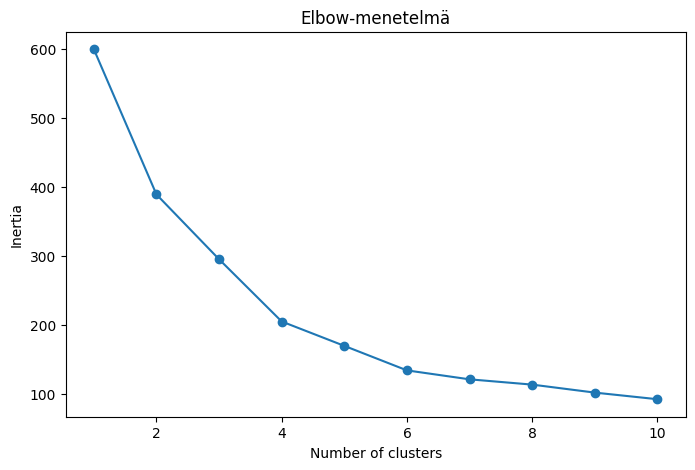

In [5]:
# Määritetään optimaalinen klustereiden lukumäärä k elbow-menetelmällä
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Piirretään elbow-menetelmän tulokset viivakuvioon ja päätetään sopivin arvo k:lle
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow-menetelmä')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Tämän elbow-menetelmän viivakuvion mukaan **$k=5$** olisi ideaalinen klusterien lukumäärä.

## Klusterointialgoritmin soveltaminen

Pythonin _scikit-learn_-kirjaston avulla $k$-means alritmin suorittaminen on suoraviivaista. Ninhän itse asiassa jo tehtiin edellä elbow-menetelmää sovellettaessa. Nyt niin tehdään vielä kerran valitulla klustereiden lukumäärän $k$:n arvolla.

In [6]:
# Sovelletaan k-means-algoritmia arvolla k=5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# Lisästään klusterin tunnisteet alkuperäiseen aineistoon uutena ominaisuutena
df['Cluster'] = kmeans.labels_

Jokainen aineiston piste eli asiakas kuuluu johonkin viidestä klusterista ja jokaisella klusterilla on tunnistenumeronsa $0,\ldots,4$.. Kun $k$-means-algoritmia sovellettiin, tietokehykseen tallennettiin jokaisen asiakkaan osalta klusterin tunnistetieto. Tämä auttaa tulosten visualisoinnissa ja tulosten analysoinnissa.

## Tulosten visualisointi

Klusterien määrän ollessa kaksi tai enemmän, tuloksia voi visualisoida useammlla eri tavalla. Yksinkertainen mutta toimiva tapa on käyttää hajontakuviota, jossa eri klustereilla on oma värinsä. Mikäli tällä tavalla saadaan ainakin joitain selkeitä ryhmiä eroteltua muista, klusteroinnista on ollut hyötyä.

Piirretään seuraavassa klusterit, joihin asiakkaat kuuluvat aineiston taloustilannetta kuvaavan muuttujan (vuosituolot ja kulutusaste) mukaan. Tästä saadaan varsin mielenkiintoinen asiakassegmentointi.

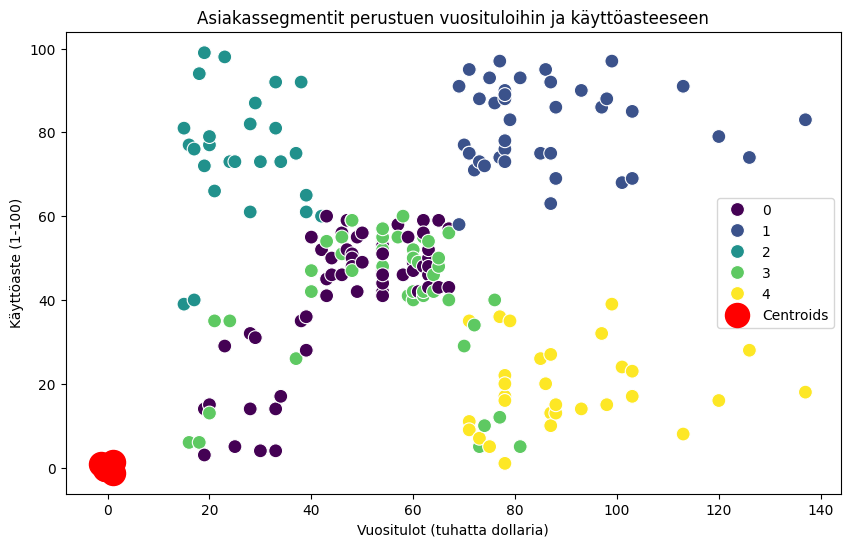

In [7]:
# Visualisoidaan klusterit, jotka käyttävät muuttujia vuositulot ja käyttöaste
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=df['Cluster'], palette='viridis', s=100)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red', label='Centroids')
plt.title('Asiakassegmentit perustuen vuosituloihin ja käyttöasteeseen')
plt.xlabel('Vuositulot (tuhatta dollaria)')
plt.ylabel('Käyttöaste (1-100)')
plt.legend()
plt.show()

## Klustrerien hyvyyden arviointi

Kuviosta nähdään, että asiakkaiden segmentointi ei ole alkuunkaan täydellinen. Etenkin ryhmät 0 ja 3 näyttävät menevän aivan päällekkäin. Tulos auttaa kuitenkin analysoinnissa asiakassegmenttien luomisessa.

## Tulosten tulkinta

Yleisesti ottaen asiakkaat vidaan luokitella monin eri tavoin heidän taloudellisen profiilinsa ja kulutuskäyttäytymisensä mukaan. Tuloksista nähdään ainakin seuraavia asioita:
* klusteri 0: alhainen tulotaso, vähän kuluttavat asiakkaat, jotka tuskin kiinnittyvät tiettyyn merkkiin vaan ovat ennen kaikkea hintatietoisia
* klusteri 1: alhainen tulotaso, paljon kuluttavat asiakkaat, luultavimmin ryhmä usein käyviä asiakkaita, jotka käyttävät suuren osan tuloistaan kauppakeskuksissa yleensäkin ja/tai asuvat lähistöllä
* klusteri 2: keskituloisista kovatuloisiin, paljon kuluttavia asiakkaita, luultavimmin yritysten tärkeimpiä asiakkaita
* klusteri 3: keskituloisista kovatuloisiin, vähän kuluttavat asiakkaat, luultavimmin varakkaita ja jopa rikkaita asiakkaita, jotka kuluttavat rahaa valikoidusti
* klusteri 4: keskituloiset, keskimääräinen rahankulutus, edustavat keskimääräistä asiakassegmenttia, joilla on tasapainoiset kulutustavat.

Nämä näkemykset voidaan hyödyntää kohdennettuina mainosstrategioina asiakkaille, esim. kullekin rymälle omina mainoksina tai uutiskirjeinä. Tai ne voidaan yhdistää muihin analyyseihin ja pyrkiä pitämään tietyt hpaljon kuluttavat asiakkaat tai saada vähän kuluttavat asiakkaat kuluttamaan enemmän.

On kuirenkin hyvä huomata, että elbow-menetelmästä saatu klusterien lukumäärä ei ole aina se ainoa oikea vaan muitakin kokeilla. Tässä esimerkissä arvo $k=4$ saattaisi auttaa ryhmien 0 ja kolme päällekkäisyyden kanssa.

Lähteet ja kirjallisuus:

* [What is cluster analysis and when should you use it?](https://www.qualtrics.com/en-gb/experience-management/research/cluster-analysis/)
* [7 Data Insights: How Cluster Analysis Fuels Business Growth](https://www.numberanalytics.com/blog/7-data-insights-cluster-analysis-business-growth)
* [Performing Cluster Analysis in Python: A Step-by-Step Tutorial](https://www.statology.org/performing-cluster-analysis-in-python-a-step-by-step-tutorial/)
* [10 Clustering Algorithms With Python](https://machinelearningmastery.com/clustering-algorithms-with-python/)
* [Cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis)

In [8]:
import datetime
print(f'Last modified {datetime.datetime.now():%Y-%m-%d %H:%M} by Juha Nurmonen')

Last modified 2025-10-25 23:02 by Juha Nurmonen
